# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])

from sqlalchemy import create_engine

from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import pickle

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import workspace_utils
from workspace_utils import active_session

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///messages_data.db')
df = pd.read_sql_table('messages', engine)

X = df.message
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1)

In [3]:
x = df.drop(['id', 'message', 'original'], axis=1).groupby('genre').sum().T

x.sum(axis=1)
#.plot(kind='bar', figsize=(18,8))

related                   20282
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

In [4]:
# Let us see the distribution of target values

(Y.sum()/Y.shape[0]).plot(kind='bar', figsize=(20,5));

As we can see the except for a few columns (aid_related, weather_related, direct_report) data in most of the target columns is zero. The data is imbalanced and challenge lies in correctly identifying True-Positives while minimizing False-Positives and False-Negatives. The aim is to maximize both recall and precision score. 

However, since we are dealing with disaster response cases, we should give more weightage to recall score than precision score.

We will use $F_\beta$ as our primary measure of score with $\beta=2$


### 2. Write a tokenization function to process your text data

Do messages contain urls? if so, we should consider replacing them in our tokenizer

In [5]:
# Check if messages contain urls? if so, we should consider replacing them in our tokenizer

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
def has_url(text):
    return True if re.search(url_regex, text) else False

df.message.apply(has_url).sum()/df.shape[0]

0.025518767165090023

In [6]:
def tokenize(text):
    """
    Processes the inputs by normalizing, tokenizing and converting to word stems
    
    Args: 
    text: text to be processes
    
    Returns:
    tokens: the processed and tokenized list of words
    """
    
    # Remove urls from text
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # convert to lowe-case and remove any special characters.
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    words = word_tokenize(text)
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    # filter out the stop-words and lemmatize
    tokens = [lemmatizer.lemmatize(word.strip()) for word in words if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=42)

# fit the pipeline
model = pipeline.fit(X_train, y_train)



### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
y_pred = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              F1     Fbeta  accuracy  precision    recall
label                                                                    
related                 0.939801  0.921754  0.916667   0.979167  0.916667
request                 1.000000  1.000000  1.000000   1.000000  1.000000
offer                   0.904762  0.909586  0.916667   0.924242  0.916667
aid_related             0.985915  0.977654  0.972222   1.000000  0.972222
medical_help            0.985915  0.977654  0.972222   1.000000  0.972222
medical_products        0.936027  0.939643  0.944444   0.947712  0.944444
search_and_rescue       1.000000  1.000000  1.000000   1.000000  1.000000
security                0.936027  0.939643  0.944444   0.947712  0.944444
military                0.904762  0.909586  0.916667   0.924242  0.916667
child_alone             0.985915  0.977654  0.972222   1.000000  0.972222
water                   1.000000  1.000000  1.000000   1.000000  1.000000
food                    0.936027  0.93

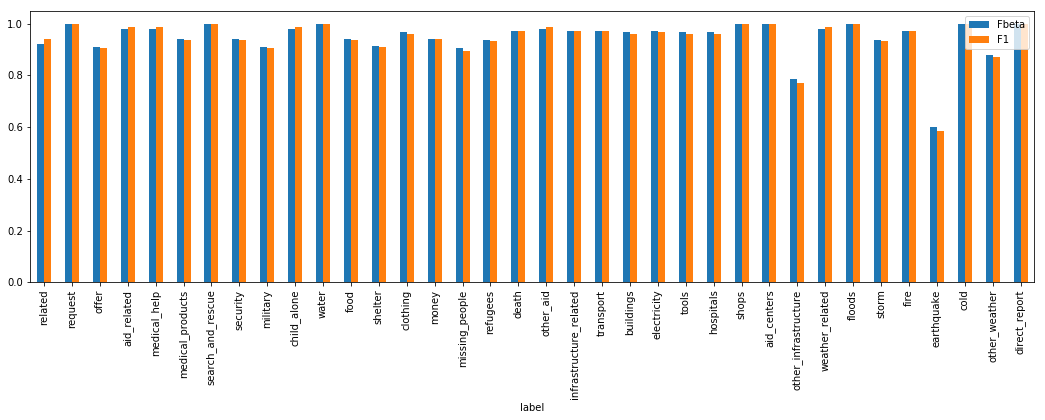

In [10]:
def calculate_scores(actuals, predicted, labels):
    scores = []
    for i,label in enumerate(labels):
        scores.append({
            'label': label,
            'accuracy': accuracy_score(actuals[i], predicted[i]),
            'precision': precision_score(actuals[i], predicted[i], average='weighted'),
            'recall': recall_score(actuals[i], predicted[i], average='weighted'),
            'F1': f1_score(actuals[i], predicted[i], average='weighted'),
            'Fbeta': fbeta_score(actuals[i], predicted[i], beta=2, average='weighted')

        })
    scores = pd.DataFrame.from_dict(scores).set_index('label')
    return scores

labels = y_test.columns.values
scores = calculate_scores(y_test.values, y_pred, labels)

print(scores)
scores[['Fbeta','F1']].plot(kind='bar', figsize=(18,5));

### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f678e9aa730>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

In [12]:
parameters = {
    'vect__max_df': (0.5, 1.0),
    'tfidf__use_idf': (True, False),
    'clf__estimator__n_estimators': [10, 30],
    'clf__estimator__min_samples_split': [2, 5, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=3, verbose=2, n_jobs=-1)
with active_session():
    cv.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5, total=  46.9s
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   58.2s remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5, total=  46.8s
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=0.5, total=  46.9s
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=1.0 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=1.0, total=  46.6s
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=1.0 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=1.0, total=  46.9s
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__max_df=1.0 
[CV]  clf__estimator__min_sa

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 102.4min finished


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              F1     Fbeta  accuracy  precision    recall
label                                                                    
related                 0.957516  0.947105  0.944444   0.981481  0.944444
request                 1.000000  1.000000  1.000000   1.000000  1.000000
offer                   0.864583  0.875791  0.888889   0.901961  0.888889
aid_related             0.985915  0.977654  0.972222   1.000000  0.972222
medical_help            0.985915  0.977654  0.972222   1.000000  0.972222
medical_products        0.970452  0.971087  0.972222   0.973064  0.972222
search_and_rescue       1.000000  1.000000  1.000000   1.000000  1.000000
security                0.970452  0.971087  0.972222   0.973064  0.972222
military                0.904762  0.909586  0.916667   0.924242  0.916667
child_alone             0.985915  0.977654  0.972222   1.000000  0.972222
water                   1.000000  1.000000  1.000000   1.000000  1.000000
food                    0.936027  0.93

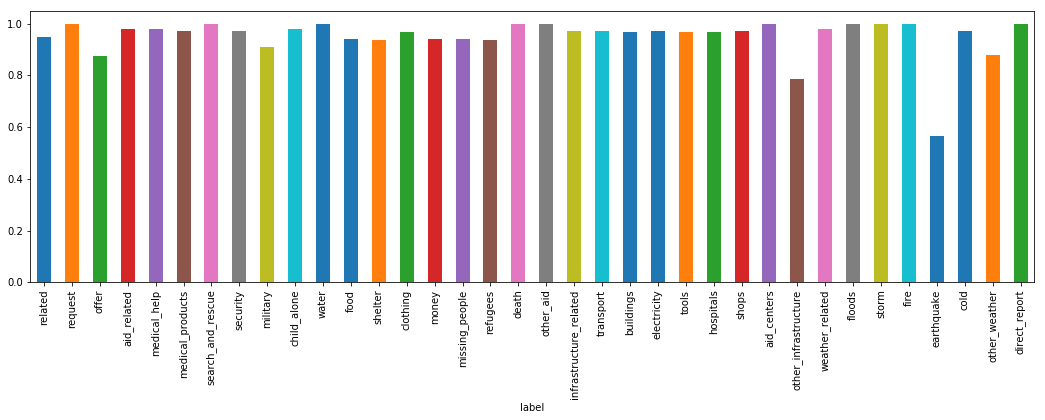

In [13]:
y_pred = cv.predict(X_test)

labels = y_test.columns.values
scores = calculate_scores(y_test.values, y_pred, labels)

print(scores)
scores.Fbeta.plot(kind='bar', figsize=(18,5));


Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 30, 'tfidf__use_idf': True, 'vect__max_df': 0.5}


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0,0.5,'Iterations')

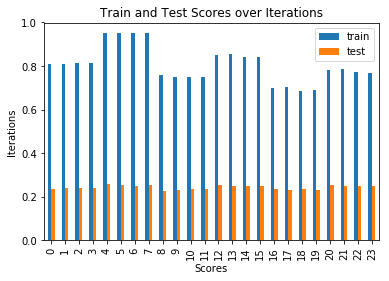

In [14]:
print("\nBest Parameters:", cv.best_params_)
mean_scores = pd.DataFrame([cv.cv_results_['mean_train_score'],cv.cv_results_['mean_test_score']], index=['train','test'])

ax = mean_scores.T.plot(kind='bar', title='Train and Test Scores over Iterations')
ax.set_xlabel("Scores")
ax.set_ylabel("Iterations")

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [10, 50]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, verbose=3)

with active_session():
    cv_ada.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10, score=0.1494196501553049, total=  25.3s
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.5s remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10, score=0.1391204838973353, total=  25.9s
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=10, score=0.16462318129802192, total=  25.5s
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50, score=0.1441883276115743, total= 1.3min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50, score=0.1476213830308975, total= 1.3min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=50, score=0.13437959784207945, total= 1.3min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=10, score=0.12604217753800884, total=  25.7s
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_est

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 12.5min finished


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                              F1     Fbeta  accuracy  precision    recall
label                                                                    
related                 0.899668  0.876130  0.861111   0.941840  0.861111
request                 0.958529  0.966698  0.972222   0.945216  0.972222
offer                   0.833333  0.833333  0.833333   0.833333  0.833333
aid_related             1.000000  1.000000  1.000000   1.000000  1.000000
medical_help            0.971429  0.955056  0.944444   1.000000  0.944444
medical_products        0.807407  0.787037  0.777778   0.853175  0.777778
search_and_rescue       1.000000  1.000000  1.000000   1.000000  1.000000
security                0.893532  0.905209  0.916667   0.923810  0.916667
military                0.904762  0.909586  0.916667   0.924242  0.916667
child_alone             1.000000  1.000000  1.000000   1.000000  1.000000
water                   1.000000  1.000000  1.000000   1.000000  1.000000
food                    0.936027  0.93

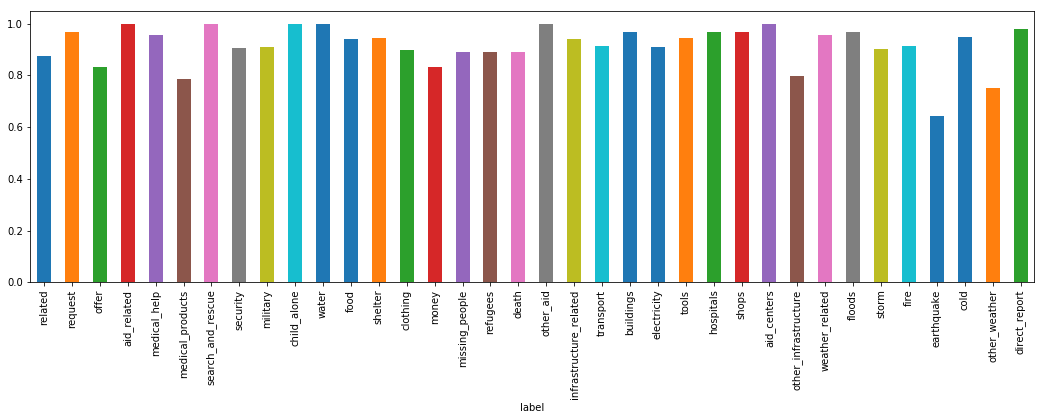

In [19]:
y_pred = cv_ada.predict(X_test)

labels = y_test.columns.values
scores = calculate_scores(y_test.values, y_pred, labels)

print(scores)
scores.Fbeta.plot(kind='bar', figsize=(18,5));


Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 30, 'tfidf__use_idf': True, 'vect__max_df': 0.5}


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0,0.5,'Iterations')

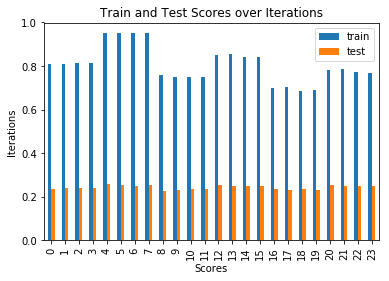

In [20]:
print("\nBest Parameters:", cv.best_params_)
mean_scores = pd.DataFrame([cv.cv_results_['mean_train_score'],cv.cv_results_['mean_test_score']], index=['train','test'])

ax = mean_scores.T.plot(kind='bar', title='Train and Test Scores over Iterations')
ax.set_xlabel("Scores")
ax.set_ylabel("Iterations")

### 9. Export your model as a pickle file

In [21]:
import pickle

with open('trained_model.pkl', 'wb') as pickle_file:
    pickle.dump(cv, pickle_file, fix_imports=True)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.